In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import json 
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import pickle

from laneDetectionHelperFunctions import *

import random
from CNNModel import cnn_model

Using TensorFlow backend.


# Setup parameters for ROI selection on preprocessed test image before input to the model

In [2]:
LOWER_LEFT_POINT = [0, 80]
UPPER_LEFT_POINT = [0, 40]
UPPER_RIGHT_POINT = [160, 30]
LOWER_RIGHT_POINT = [160, 80]
VERTICES = np.array([[LOWER_LEFT_POINT, UPPER_LEFT_POINT, UPPER_RIGHT_POINT, LOWER_RIGHT_POINT]], dtype=np.int32)

# Load CNN model

In [3]:
import keras
model = keras.models.load_model('CNN_model.h5')

# Load test images and test labels

In [4]:
try:
    tusimple_test_images = pickle.load(open("tusimple_test_images.p", "rb" ))
    tusimple_test_labels = pickle.load(open("tusimple_test_labels.p", "rb" ))
except:
    tusimple_test_images = []
    tusimple_test_labels = []
    json_gt = [json.loads(line) for line in open('test_label.json')]
    for gt in json_gt:
        # Get image
        image = cv2.imread(gt['raw_file'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resize_image = cv2.resize(image, (160, 80), interpolation = cv2.INTER_AREA)
        tusimple_test_images.append(resize_image)
        # Generate label
        gt_lanes = gt['lanes']
        y_samples = gt['h_samples']
        gt_lanes_vis = [[(x,y) for (x,y) in zip(lane,y_samples) if x >= 0] for lane in gt_lanes]
        label = get_label(image, gt_lanes_vis, 5)

        resize_label = cv2.resize(label, (160, 80), interpolation = cv2.INTER_AREA)
        reshape_label = np.zeros((80, 160, 1))
        reshape_label[:, :, 0] = resize_label[:,:]
        tusimple_test_labels.append(reshape_label)

    pickle.dump(tusimple_test_images, open("tusimple_test_images.p", "wb") )
    pickle.dump(tusimple_test_labels, open("tusimple_test_labels.p", "wb"))

## Visualise test images and its corresponding labels

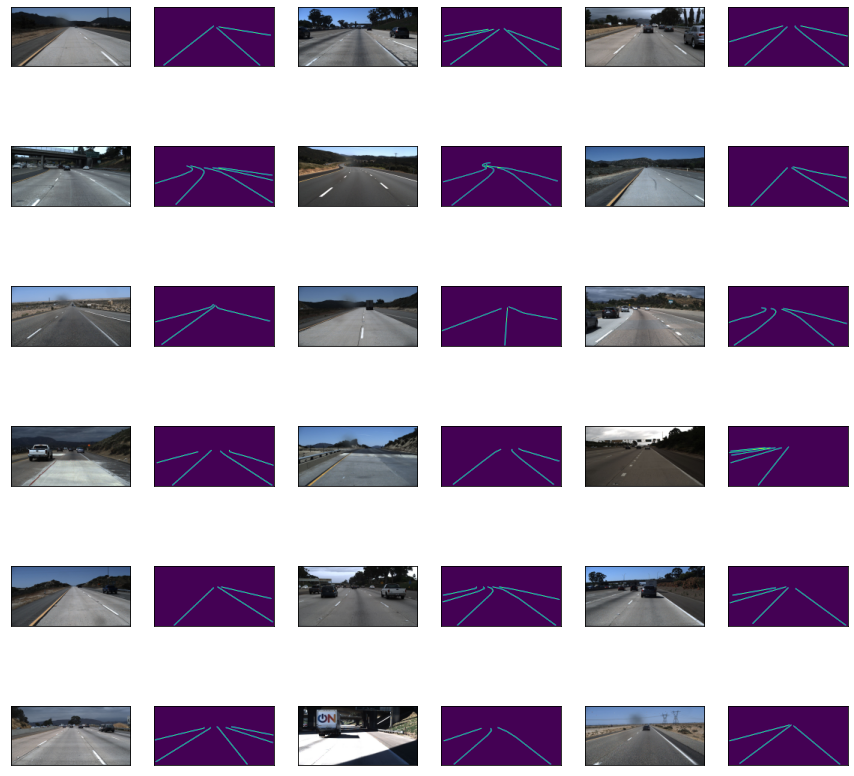

In [5]:
visualize_data_and_label(tusimple_test_images, tusimple_test_labels)

# Pre-processing test images before input to the model (same approach as pre-processing training images)

In [6]:
# Pre processing steps including Gray Scaling, Gaussian Blurring, Edge Detecting
pre_process_test_images = [region_of_interest(pre_process(img), VERTICES) for img in tusimple_test_images]

test_images = []
# In order to input image to model we need to convert them from 2D to 3D
for img in pre_process_test_images:
    reshape_img = reshape_2D_to_3D(img)
    test_images.append(reshape_img)
    
test_images = np.array(test_images)
test_labels = np.array(tusimple_test_labels)


## Visualise pre-processed test images and its corresponding labels

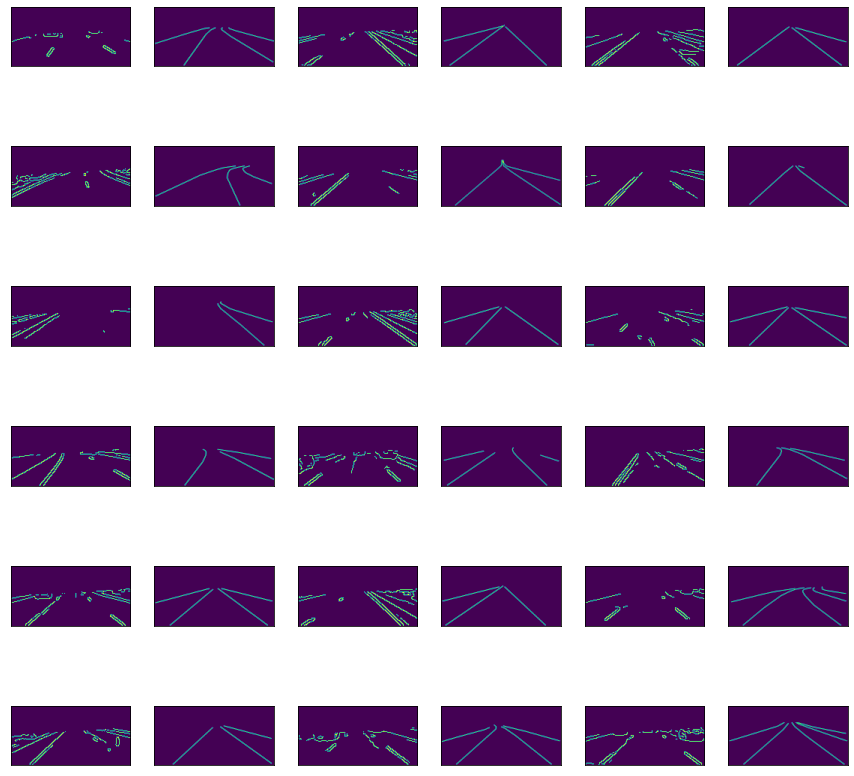

In [7]:
visualize_data_and_label(test_images, test_labels)

# Model predictions

In [8]:
prediction_images = [predict(model, test_image) for test_image in test_images]

## Visualise raw predictions from model after input all pre-processed test images into the model

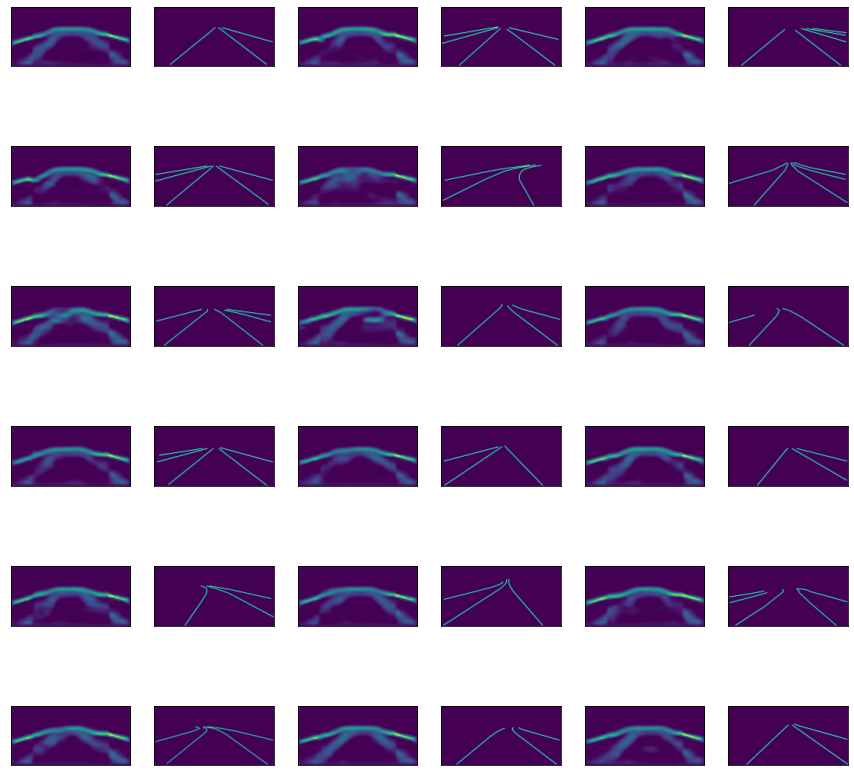

In [9]:
visualize_data_and_label(prediction_images, test_labels)

# Post processing predictions

In [10]:
post_images = [post_process(prediction_image) for prediction_image in prediction_images]

## Visualise final predictions and its labels from the ground truth

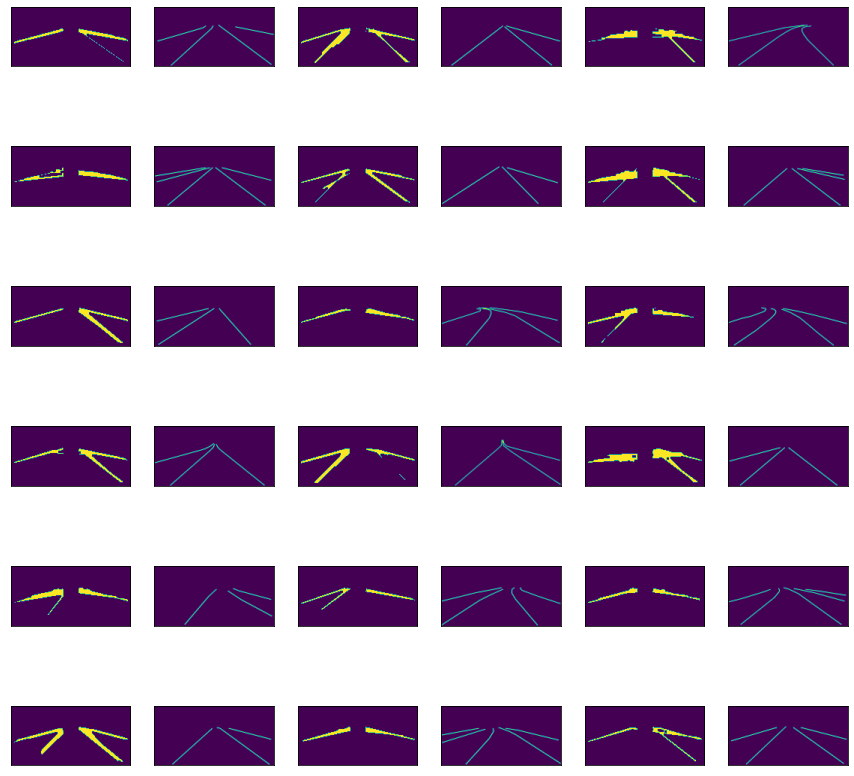

In [11]:
visualize_data_and_label(post_images, test_labels)

# Evaluation

Make those previous post images as binary images

In [12]:
threshold_post_images = [cv2.threshold(post_image, 1, 255, cv2.THRESH_BINARY)[1] for post_image in post_images]
post_images = threshold_post_images

Make test labels as binary images

In [13]:
threshold_test_labels = []
for test_label in test_labels:
    dilated_test_label = cv2.dilate(test_label,(5,5),iterations = 1)
    dilated_test_label = dilated_test_label.astype('uint8')
    threshold_test_labels.append(cv2.threshold(dilated_test_label, 1, 255, cv2.THRESH_BINARY)[1])
test_labels = threshold_test_labels

<code>compare_binary_images</code> function takes a label image and predicted label and counts true positives, false positives, true negatives and false negatives according to their pixel vales. 
The function outputs precision, recall and accuracy values to evaluate how accuracy of the predicted label compares to its ground truth label.

In [14]:
def compare_binary_images(true_label, predict_label):
    TP, FP, TN, FN = 0, 0, 0, 0
    height = true_label.shape[0]
    width = true_label.shape[1]
    for row in range(height):
        for column in range(width):
            true_pixel = true_label[row, column]
            predict_pixel = predict_label[row, column]
            if true_pixel == 255 and predict_pixel == 255:
                TP += 1
            elif true_pixel == 0 and predict_pixel == 255:
                FP += 1
            elif true_pixel == 0 and predict_pixel == 0:
                TN += 1
            elif true_pixel == 255 and predict_pixel == 0:
                FN += 1
    P = TP + FN
    N = FP + TN
    
    precision = TP/(TP+FP)
    recall = TP/P
    accuracy = (TP+TN)/(P+N)
    return (precision, recall, accuracy)

## Compute average precisions, recalls and accuracies from all test images

In [15]:
precisions, recalls, accuracies = [], [], []
for (test_label, post_image) in zip(test_labels, post_images):
    precision, recall, accuracy = compare_binary_images(test_label, post_image)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

In [16]:
precisions = np.array(precisions)
recalls = np.array(recalls)
accuracies = np.array(precisions)
print("Average precisions is", np.average(precisions))
print("Average recalls is", np.average(recalls))
print("Average accuracies is", np.average(accuracies))

Average precisions is 0.30859648435165976
Average recalls is 0.2395074413133615
Average accuracies is 0.30859648435165976


# Put things together

## This is for illustration purposes only

In [17]:
sub_test_images = tusimple_test_images[:100]
sub_test_labels = test_labels[:100]
sub_post_images = post_images[:100]
blanks = np.zeros_like(sub_test_labels[0]).astype(np.uint8)
combined_predict_images = []
combined_label_images = []
for index, (sub_post_image, sub_test_label) in enumerate(zip(sub_post_images, sub_test_labels)):
    predict_lane = np.dstack((blanks, sub_post_image, blanks))
    gt_lane = np.dstack((blanks, sub_test_label, blanks))
    combined_predict_images.append(cv2.addWeighted(sub_test_images[index], 1, predict_lane, 1, 0))
    combined_label_images.append(cv2.addWeighted(sub_test_images[index], 1, gt_lane, 1, 0))

## Visualise predicted images and label images

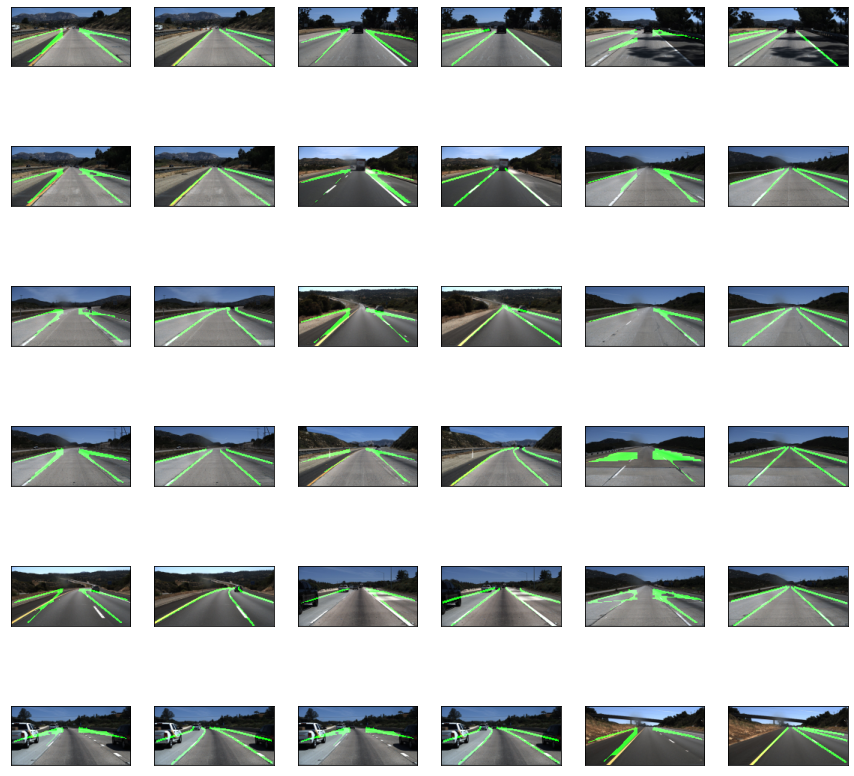

In [18]:
visualize_data_and_label(combined_predict_images, combined_label_images)